# MATH 60210 - H2022


## Nasim Siami





In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from scipy.stats import probplot

# the following configures pandas_datareader and its cache.
import os
import pandas_datareader as pdr
import requests_cache

expire_after = dt.timedelta(days=3)
session = requests_cache.CachedSession(
    cache_name=os.path.expanduser('~/.cache/requests_cache'),
    backend='sqlite',
    expire_after=expire_after)

# What are the datasets available in Ken French's Data Library? See for yourself!
TheBigList = pd.DataFrame(pdr.famafrench.get_available_datasets(session=session),columns=['Dataset_Name'])
#print(TheBigList)

## Question 1

We spend a lot of time examining the behaviour of US markets, so for this question we'll look at the *rest* of the world.

### Part a

Write a function that accepts the name of a dataset in Ken French's Data Library and returns the dataset.

- Your function should use `pandas_datareader()` to retrieve the dataset.
- It should allow for users to specify starting and ending dates in datatime format.
- It should print the description of the dataset description (i.e. ds['DESCR']) unless `descr=False`.
- If the name of the dataset is not valid, it should print an error message and return a DataFrame containing the list of valid dataset names.
- **You should use the cache when coding with `pandas_datareader`.** (It's polite *and* makes your code run faster!)



In [2]:
def GetFrench(dsname, start=None, end=None, descr=True):
    """
    Retrieves dataset from Ken French's Data Library
    Arguments:
        dsname    [Python string] name of dataset
    """
 
    TheBigList = pdr.famafrench.get_available_datasets(session=session)
    if dsname in TheBigList:
        ds = pdr.DataReader(dsname, 'famafrench', start=start, end=end,session=session)
        if descr:
            print('\n')
            print(ds['DESCR'])
        return ds
    else:
        print(f'\nThe dataset name {dsname} could not be found!')
        print('\nReturning a list of the currently available datasets.')
        return pd.DataFrame(TheBigList,columns=['Dataset_Name'])
    
  

## Part b

Write a function that accepts two DataFrames

- a set of $N$ portfolios excess returns
- a set of $K < N$ market factors

and then estimates a linear asset pricing model. 

Your function should return 

- the estimated risk premium on each factor
- the loading of each portfolio on each of the factors
- the J-statistic and its p-value.

Your function should also have an option `TradedFactors` to indicate whether or not the factors are composed of assets that are traded in the market.



In [4]:
from linearmodels.asset_pricing import TradedFactorModel
from linearmodels.asset_pricing import LinearFactorModel
from linearmodels.asset_pricing import LinearFactorModelGMM


def AssetPricer(Ports,Facts,TradedFactors=True): 
    """
    This function prices the assets using a linear asset pricing model
    Arguments:
        Ports     a DataFrame of asset excess returns
        Facts     a DataFrame of asset pricing factors
        TradedFactors     [Boolean] If True, the risk premium for each factor may be estimated by the factor's mean.
    Returns:
        lambdas     a 1-D DataFrame containing the estimated risk premium of each factor
        betas       a 2-D DataFrame containing the loadings of each asset on each factor
        pr_err      a 1-D DataFrame containing the estimated pricing errors for each asset
        J           [real scalar] the J-statistic for the null hypothesis of correct specification
        pval        [real scalar] the J-statistic's p-value
    """

    if TradedFactors:
        APmod = TradedFactorModel(Ports,Facts)
    else:
        APmod = LinearFactorModel(Ports,Facts)
    APout = APmod.fit()
    
    lambdas = APout.risk_premia
    betas   = APout.betas
    pr_err  = APout.alphas
    J       = APout.j_statistic.stat
    pval    = APout.j_statistic.pval
    
  
    return lambdas, betas, pr_err, J, pval

In [5]:
# Let's hope that your GetFrench() function works!
ports = GetFrench('Developed_ex_US_25_Portfolios_ME_INV_Daily', start='2018', end='2021', descr=False)
facts = GetFrench('Developed_ex_US_5_Factors_Daily', start='2018', end='2021', descr=False)
# Let's not forget to subtract the risk-free rate from the asset returns
Xports = ports[0].sub(facts[0]['RF'],axis='index')

l, b, pe, J, pv = AssetPricer(Xports,facts[0])
# some Autotests.....
assert np.isclose(l[2], -0.044739)
assert np.allclose(b.loc['ME4 INV1'], [1.077641,  0.289283,  0.121409,  0.039462,  0.182125, -1.700755])
assert np.isclose(pe.loc['BIG HiINV'], 0.0029599623)
assert np.isclose(J, 26.711869)
assert np.isclose(pv, 0.3704306)

l, b, pe, J, pv = AssetPricer(Xports,facts[0],TradedFactors=False)
# No Hidden tests this time! You get all the points for passing the visible tests.
assert np.isclose(l[3], 0.025815, atol=1e-5)
assert np.allclose(b.loc['ME2 INV3'], [0.970667,  0.760196,  0.176492, -0.080324, -0.152855,  0.837902])
assert np.isclose(pe.loc['SMALL HiINV'], 0.000010, atol=1e-6)
assert np.isclose(J, 10.070285)
assert np.isclose(pv, 0.9511906)


/usr/local/lib/python3.8/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_categorical(s):


/usr/local/lib/python3.8/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_categorical(s):


## Part c

The portfolios that were downloaded by the autotest for Part b were

- 25 Portfolios formed on Size and Investment (`Developed_ex_US_25_Portfolios_ME_INV_Daily`)
and the factors that were used were 
- 5 Fama/French factors  (`Developed_ex_US_5_Factors_Daily`) 

For this question, 

- dowload those series for the period 2000-2021, 
- also download the momentum factor (`Developed_ex_US_Mom_Factor_Daily`) for the same period and add it to your set of factors. 

Re-estimate the linear pricing model appropriately with your new data sample and your new set of factors.<br>
**Which factors seem to have statistically significant risk premia?**

Be sure to 

- show your code below
- display the relevant output
- answer the question.



In [7]:
# Your code goes here.

# Get the portfolios and risk factors
# Note the [0]'s at the end ... to store just the data.
ports = GetFrench('Developed_ex_US_25_Portfolios_ME_INV_Daily', start='2000', end='2021', descr=False)[0] 
facts = GetFrench('Developed_ex_US_5_Factors_Daily', start='2000', end='2021', descr=False)[0]
facts['WML'] = GetFrench('Developed_ex_US_Mom_Factor_Daily', start='2000', end='2021', descr=False)[0]
# We need to substract the risk-free rate from the portfolio returns
ports = ports.sub(facts['RF'],axis=0)
# Check the portfolios...
print(ports.head())
# We should drop the risk-free rate from the set of factors
facts = facts.drop(columns='RF')
# Check the risk factors...
facts.head()

            SMALL LoINV  ME1 INV2  ME1 INV3  ME1 INV4  SMALL HiINV  ME2 INV1  \
Date                                                                           
2000-01-03         1.89      1.97      2.18      2.42         2.35      1.79   
2000-01-04        -0.65     -0.62     -0.78     -0.87        -0.96     -1.17   
2000-01-05        -1.87     -1.43     -1.32     -1.90        -2.72     -1.95   
2000-01-06        -0.64     -0.96     -0.06     -0.27        -0.02     -0.61   
2000-01-07         0.80      0.68      0.66      0.86         1.26      0.88   

            ME2 INV2  ME2 INV3  ME2 INV4  ME2 INV5  ...  ME4 INV1  ME4 INV2  \
Date                                                ...                       
2000-01-03      1.83      1.81      1.92      2.29  ...      1.85      1.53   
2000-01-04     -1.02     -1.29     -1.51     -1.67  ...     -1.42     -1.38   
2000-01-05     -1.28     -1.31     -2.25     -2.53  ...     -1.97     -1.94   
2000-01-06     -0.79     -0.35     -0.13    

,Mkt-RF,SMB,HML,RMW,CMA,WML
Date,,,,,,
2000-01-03,1.23,0.92,-0.48,0.13,-0.50,1.16
2000-01-04,-2.51,1.18,1.15,-0.65,0.25,0.01
2000-01-05,-2.86,0.78,2.44,-1.16,2.42,-4.08
2000-01-06,-1.48,0.91,0.54,-0.73,0.70,-1.70
2000-01-07,1.07,-0.21,-0.12,0.04,0.38,-0.31


In [8]:

# Momentum is based on traded assets, so we can use TradedFactorModel()
TFmod =  TradedFactorModel(ports,facts)
# Of course, LinearFactorModel() is still valid, if less efficient....
LFmod = LinearFactorModel(ports,facts)
# To see which factors have statistically significant risk premia, 
print('Summary of risk premia (Assuming traded factors):')
print(TFmod.fit())
print('Summary of risk premia (Allowing for non-traded factors)')
print(LFmod.fit())

/usr/local/lib/python3.8/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  if is_categorical(s):


Summary of risk premia (Assuming traded factors):
                      TradedFactorModel Estimation Summary                      
No. Test Portfolios:                 25   R-squared:                      0.9451
No. Factors:                          6   J-statistic:                    70.536
No. Observations:                  5480   P-value                         0.0000
Date:                  Mon, Apr 11 2022   Distribution:                 chi2(25)
Time:                          16:00:35                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0168     0.0137     1.2322     0.2179     -0.009

*Your written answer goes here.*

If we use `TradedFactorModel()`, we find that everything *except* SMB (firm size) and Mkt-RF (the market factor) has a risk premia that is significant at the 1% level. 

If we  use `LinearFactorModel()`, we find that only  HML and CMA are still significant.

---

# Question 2

## Part a

Write a function that takes the $Y$ and the $X$ for a linear regression and returns $\hat{\theta}$ and the log of the likelihood function at $\hat{\theta}$.

- Assume that $Y$ and $X$ are both in DataFrames.
- The option `AddConstant` controls whether or not a constant is added to the regression.
- Calculate the log likelihood function $\mathcal{L}(\hat{\theta}|\bm{Y,X})$ assuming that the errors $e_t \sim i.i.d. \; N(0,\hat{\sigma})$.
- For $\hat{\theta}$, use the OLS estimates for $\beta$ and $\sigma$.



In [9]:
from statsmodels.regression.linear_model import OLS
# The following might be handy...
from statsmodels.tools.tools import add_constant
from scipy.stats import norm

def OLSllf(y,X,AddConstant=True): 
    """
    Computes MLE of a regression using OLS. Also returns the llf.
    Arguments:
        y, X     DataFrames 
                - if y has multiple columns, only the first will be used.
                - a constant will be added to X for the regression if AddConstant == True.
                - there is no checking for missing values, colinearity, etc.
    Outputs:
        theta   - the estimated parameters = [beta, sigma]
        llf     - the log of the likelihood function
    """
    
    if AddConstant:
        OLSres = OLS(y,add_constant(X)).fit()
    else:
        OLSres = OLS(y,X).fit()
    theta_hat = OLSres.params
    theta_hat['sigma'] = np.sqrt(OLSres.scale)      
    loglik = OLSres.llf     
  
    return theta_hat, loglik

In [10]:
# Let's test that with the data on stock returns, inflation and oil prices that we used for Problem Set 1
ps1Data = pd.read_excel('PSet_1_H2022.xlsx',index_col=0)
# run the typical OLS regression
ps1mod = OLS(ps1Data['SP500'], add_constant(ps1Data[['Inflation_CPI', 'Oil Prices']]))
ps1res = ps1mod.fit()

# compare to the results from OLSllf()
th0, llf0 = OLSllf(ps1Data['SP500'], ps1Data[['Inflation_CPI', 'Oil Prices']])
assert np.all(th0[0:3] == ps1res.params)
assert th0[3] == np.sqrt(ps1res.scale) # Note the use of sqrt() here
assert llf0 == ps1res.llf



## Part b

Write a function that takes the $Y, X, \hat{\theta}$ from Part (a) above and returns 
the llf assuming that $e_t \equiv \hat{\sigma} \cdot u_t \quad u_t \sim i.i.d. \; t(\nu)$ instead of $e_t \sim i.i.d. \; N(0,\hat{\sigma})$.

- Note that $\hat{\theta}$ is **not** the MLE in this case.
- Recall that `scipy.stats` has lots of statistical functions for the Student $t$ distribution.



In [11]:
from scipy.stats import t

def OLSllf_t(y,X,th0,nu,AddConstant=True):
    """
    Takes OLS estimates of a linear regression 
    and returns the llf assuming errors are i.i.d. sigma*t(nu)
    Arguments:
        y, X    [DataFrames]
                - if y has multiple columns, only the first will be used.
                - a constant will be added to X for the regression if AddConstant == True.
                - there is no checking for missing values, colinearity, etc.
       th0      [1-D array] OLS estimates (betas,sigma)
       nu       [real] degrees of freedom for Student-t distribution. (>=1)
    Outputs:
       llf      [real scalar] the log of the likelihood function
    """
    ### BEGIN SOLUTION
    MyX = X.copy()
    if AddConstant:
        MyX = add_constant(MyX)
    k = MyX.shape[1]
    llf_t = np.sum(t.logpdf(y,nu,loc=MyX@th0[0:k],scale=th0[-1]))
    ### END SOLUTION
    return llf_t

In [12]:
# Let's keep testing with that data set from PSet 1
y = ps1Data['SP500']
X = ps1Data[['Inflation_CPI', 'Oil Prices']]
th0, llf0 = OLSllf(y, X)

assert OLSllf_t(y, X, th0, 5.0) == 438.2309847563473
assert OLSllf_t(y, X, th0, 1e5) == 441.3131914472348

X = ps1Data['Oil Prices']
th0, llf0 = OLSllf(y, X)

assert OLSllf_t(y, X, th0, 5.0) == 437.8138986348521
assert OLSllf_t(y, X, th0, 1e5) == 440.81788445477304

# Now try some hidden tests on that mysterious data set


## Part c

Write a function that 

- uses your `OLSllf()` function to estimate $\hat{\theta}$
- then makes one plot with subplots showing the profile plot for every parameter in $\hat{\theta}$.
- Each subplot should show the profile likelihood over a range of $\pm 50 \%$ of $\hat{\theta_i}$<br>(Please plot curves; no points or bar plots.)

Then using the data on stock returns, inflation and oil prices that we used for Problem Set 1, use your function to show the profile plots for the OLS parameter estimates when regressing `SP500` on a constant, `Inflation_CPI` and `Oil Prices`.

**Based only on your plots**, briefly explain

- which parameters appear to have quite asymmetric confidence intervals?
- which $\hat{\beta}$ appears to have the narrowest (in %) confidence interval?
- which $\hat{\beta}$ appears to have the widest (in %) confidence interval?



### SvN:

**Q:** Should you be using the llf for errors $\sim N(0,\sigma)$ or $\sim \sigma \cdot t(\nu)$ ?

- It's harder to do for *t-* distributed errors, since `OLSllf()` doesn't give a $\hat{\nu}.
- I'll show the results for  $N(0,\sigma)$ but I'm happy to give credit for *t-* distributed errors. 

**Q:** What role does `ss.chi2` have in the answer?

- You can calculate the exact cutoff line for the confidence interval if you want.
- I'll show how you can answer the question without it.



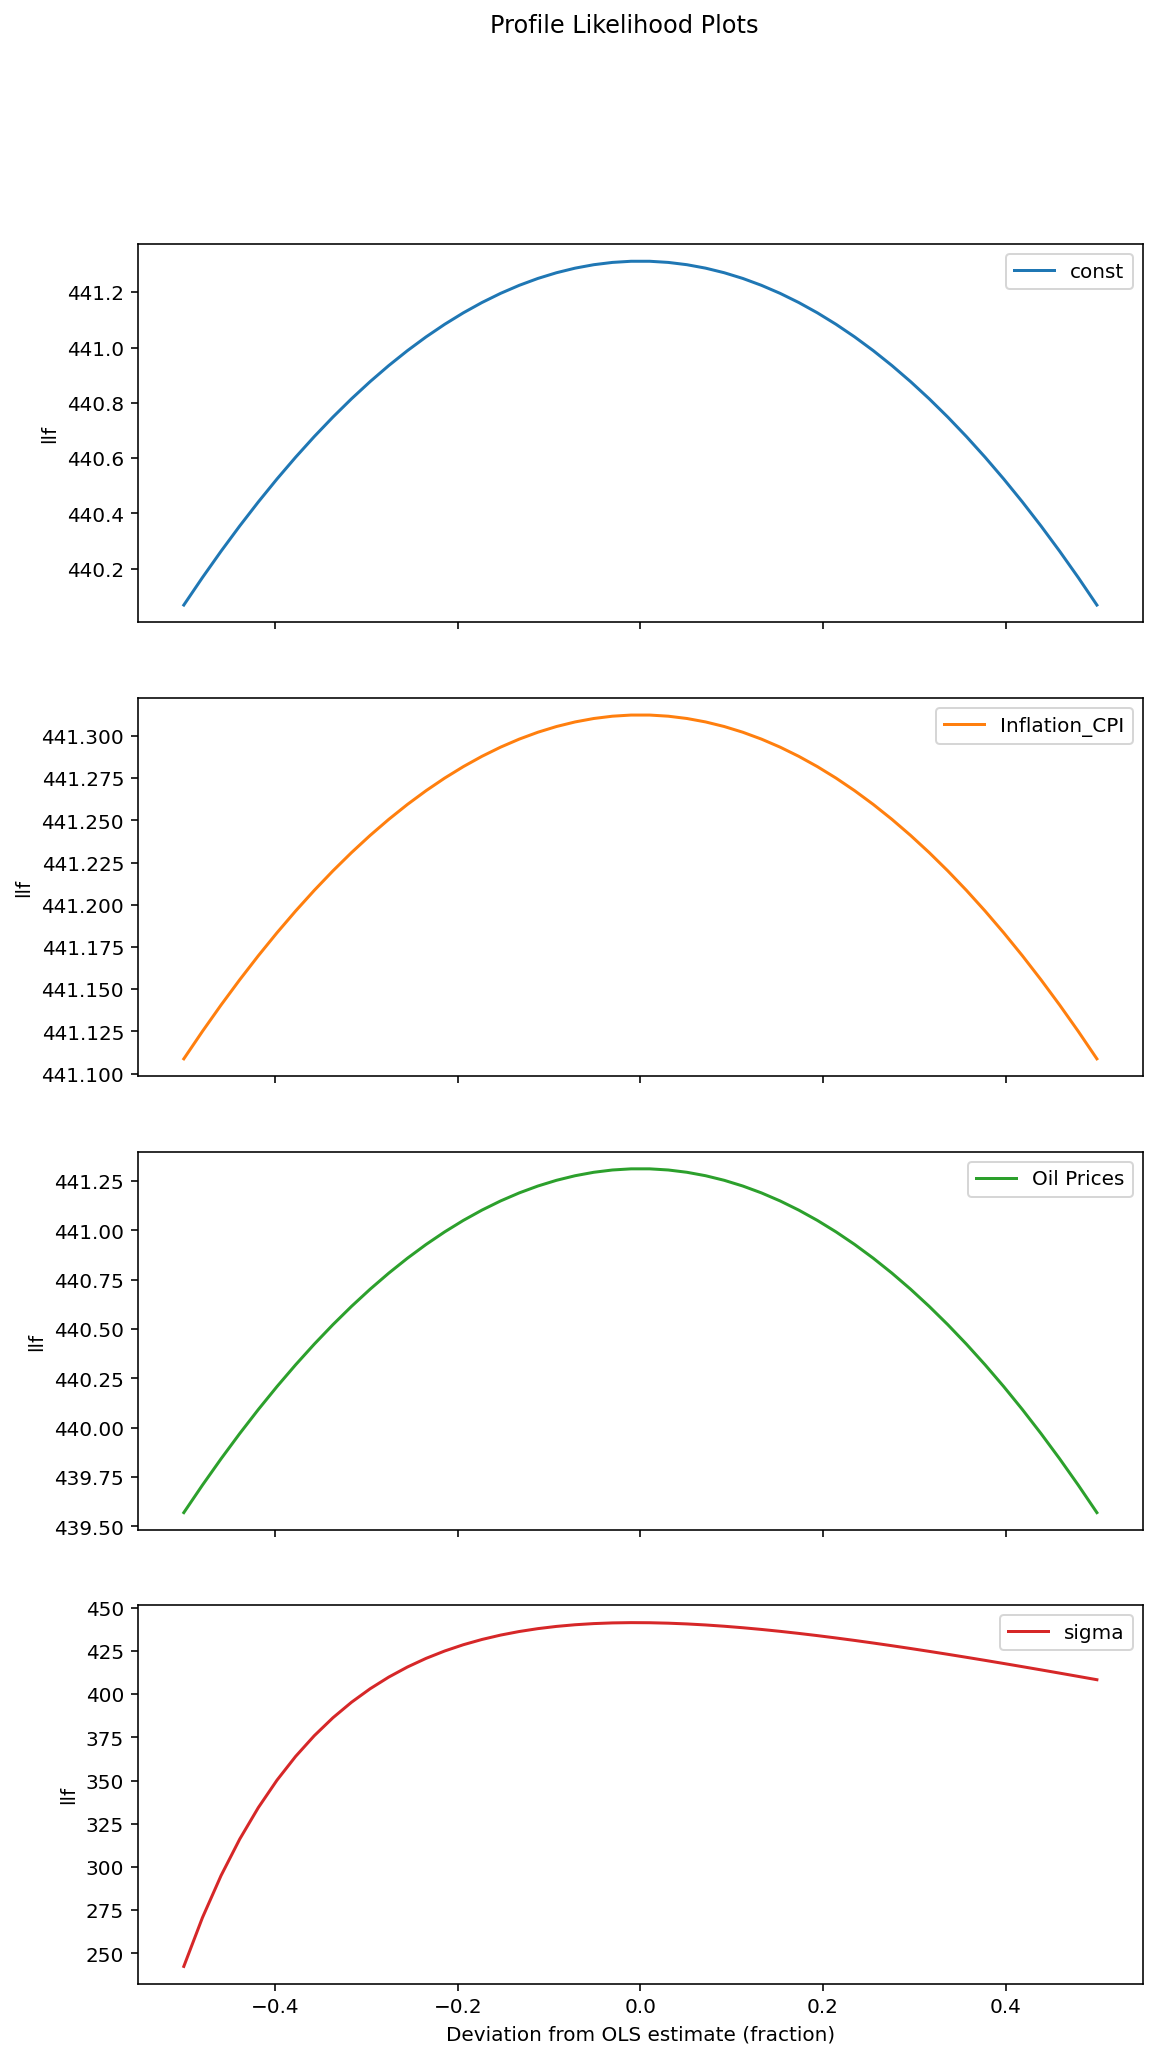

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import chi2


def profplot(y,X,AddConstant=True):
    """
    Creates profile plots 
    Arguments:     See OLSllf
    """
   
    if AddConstant:
        MyX = add_constant(X)
    else:
        MyX = X

    th0, llf0 = OLSllf(y, MyX, AddConstant)

    CV90 = chi2.ppf(.9,1)

    CI90_line = llf0 - CV90/2

    profllf = pd.DataFrame(index=np.linspace(-0.5,0.5),columns=th0.index)

    for k in th0.index:
        th = th0.copy() 
        for j in profllf.index:
            th[k] = (1+j)*th0[k].copy()

            profllf.loc[j][k] = np.sum(norm.logpdf(y,loc=MyX.dot(th.head(-1)),scale=th[-1]))

    profllf.plot(subplots=True,sharex=True,title='Profile Likelihood Plots',
                xlabel='Deviation from OLS estimate (fraction)',
                ylabel='llf', figsize=(9,16))
    

y = ps1Data['SP500']
X = ps1Data[['Inflation_CPI', 'Oil Prices']]
profplot(y, X)


- only $\sigma$ has a very asymmetric confidence interval

What can we say about the CI's?

- The horizontal line will be same distance below the peak (~441.4) in all 3 plots for the  $\hat{\beta}$'s
- Their profile plots have the same shapes *but different vertical scales.*
- $\Rightarrow$ the one that shows greatest variation in llf will have the narrowest CI
- $\Rightarrow$ the one that shows least variation in llf will have the widest CI
- $\Rightarrow$ Oil Prices must have the narrowest CI among the $\hat{\beta}$'s because their vertical scale varies the most.
- $\Rightarrow$ Inflation must have the widest CI among the $\hat{\beta}$'s  because its vertical scale varies the least.



---

# Question 3

## Part a

Use `ARCH` to write a function that accepts a DataFrame with a single series and estimates an AR(2)-GARCH(1,1) model. 

The function should 

- return the value of the log likelihood function for the estimated model 
- estimate the model with gaussian or t-distributed errors 
- return a DataFrame containing the estimated parameters, their robust standard errors and their p-values
  - be sure that the parameters are listed in the same order as shown by ARCH



In [14]:
from scipy.stats import probplot
from arch import arch_model

def AR2GARCH11(y,t_errs=False):
    """
    Estimates an AR(2)-GARCH(1,1) model.
    Arguments:
        y                 [series] data series to fit
        t_errs            [Boolean] error distribution.
                          Normal if False. Student-t if True
    Returns:
        thetaHat          [DataFrame] estimated model parameters, robust std errs and p-values
        llf               [scalar real] log of the likelihood function at thetaHat
    """
  
    # Define our model
    if t_errs:
        GarchModel = arch_model(y,mean='AR',lags=2,vol='GARCH',p=1,q=1,dist='t',rescale=True)
    else: 
        GarchModel = arch_model(y,mean='AR',lags=2,vol='GARCH',p=1,q=1,dist='normal',rescale=True)
    # Estimate the model
    My_GARCHModel = GarchModel.fit(disp='off',update_freq=0)
    # store the loglikelihood
    llf = My_GARCHModel.loglikelihood
    # Create the DataFrame of parameter estimates
    thetaHats = pd.DataFrame(My_GARCHModel.params)
    thetaHats['Std Errs'] = My_GARCHModel.std_err
    thetaHats['p_values'] = My_GARCHModel.pvalues
   
    return thetaHats, llf


In [15]:
# Let's use the GetFRED function to get some cryptocurrency data...
def GetFRED(SeriesList, start, end, dropNA=True, plot=True):
    """
    Retrieves data series from FRED
    Arguments:
        SeriesList     [Python list] names of series to retrieve
        start,end      [datetime format dates] range of series to retrieve
        dropna         [Boolean] if True, rows with missing values will be dropped
        plot           [Boolean] if True, all series will be plotted (1 series per panel)
    """
    FREDdata = pdr.DataReader(SeriesList, 'fred', start, end, session=session)
    if dropNA:
        FREDdata.dropna(axis=0, inplace=True)
    if plot:
        FREDdata.plot(subplots=True,
                      sharey=True,
                      sharex=False,
                      figsize=(16, 9))
    return FREDdata
##############################

ETHdata = GetFRED('CBETHUSD','2017-01','2022-02',plot=False)  # our data series
r_ETH = 100*ETHdata.pct_change().dropna()  # % rates of return

# Here come the tests!
thetas, llf = AR2GARCH11(r_ETH)      # estimate the model
assert llf == -5732.130758030833
assert np.allclose(thetas.iloc[0,:].values, [0.3590163, 0.111488, 0.001281], atol=1e-6)
assert np.allclose(thetas.iloc[4,:].values, [0.120468, 0.041290, 0.003528], atol=1e-6)

thetas, llf = AR2GARCH11(r_ETH,t_errs=True)      # estimate the model with t-errors
assert llf == -5594.052611686657
assert np.allclose(thetas.iloc[0:3,0].values, [0.228539, -0.084918, 0.032961], atol=1e-6)
assert np.allclose(thetas.iloc[4:7,1].values, [0.033393, 0.033860, 0.292466], atol=1e-6)
assert np.allclose(thetas.iloc[4:7,2].values, [3.880086e-06, 1.136684e-127, 6.563636e-30], rtol=1e-6)



## Part b

Write a function that takes a data series and a parameter vector for a AR(2)-GARCH(1,1) model with Student-t errors and  

- estimates the conditional volatility of the series
- provides a QQ plot of the standardized residuals<br>(e.g. with `scipy.stats.probplot()` or `statsmodels.graphics.gofplots.ProbPlot()`)

You should assume that 

- the parameters are in the same order and have the same names as those reported by ARCH.
- $h_1 = h_2 = \frac{\alpha_0}{1 - \alpha_1 - \gamma_1}$<br>(ARCH uses a slightly different starting variance estimate, so you won't be able to perfectly match their early estimates.)



In [20]:
def GARCH_PPplot(y,theta):  # modify function name and parameters
    """
    Computes the conditional volatility of an AR(2)-GARCH(1,1) with Student-t errors.
    Provides a QQ plot of the standardized residuals
    Arguments:
        y         [series] data series
        theta     [series] parameters (same order & names as reported by ARCH)
    Returns:
        ARCH_vol  [series] conditional variance 
    """
    

    # calculate the squared residuals of the AR(2)
    ar_res = y - theta.iloc[0] - theta.iloc[1]*y.shift(1) - theta.iloc[2]*y.shift(2)
    res_sq = ar_res**2

    # set up some scalars for speed in the loop
    alpha0 = theta.iloc[3]
    alpha1 = theta.iloc[4]
    gamma1 = theta.iloc[5]

    # create df for variances 
    # use unconditional variance as the starting value
    h = (alpha0/(1-alpha1-gamma1)) * np.ones_like(y)

    # start the loop at t=3 because the residuals start at t=2
    for j in range(2,len(y)-1):
        h[j+1] = alpha0 + alpha1*res_sq.iloc[j] + gamma1*h[j] 

    # standardize the residuals
    std_res = ar_res.div(np.sqrt(h),axis='rows')
    
    # Note that up until this point, the fact that we fit Student-t errors
    # instead of normal errors has made *no* difference.
    # The only difference is in the QQ plot
    
#    res_plot = sm.ProbPlot(std_res) # this uses the default (normal) distribution
    res_plot = sm.ProbPlot(std_res.dropna(axis=0),dist=t,distargs=(theta.iloc[6],)) # this uses the Student-t distribution
    res_plot.qqplot(line='45')
    plt.title("Q2C: QQ plot of t(nu) vs Standardized Residuals")
    # If we instead wanted a PP plot, we could use the following
#    res_plot.ppplot(line='45')
#    plt.title("Q2C: PP plot of t(nu) vs Standardized Residuals")
    plt.show()

    ARCH_vol = pd.DataFrame(np.sqrt(h),index=y.index)
    
    return ARCH_vol

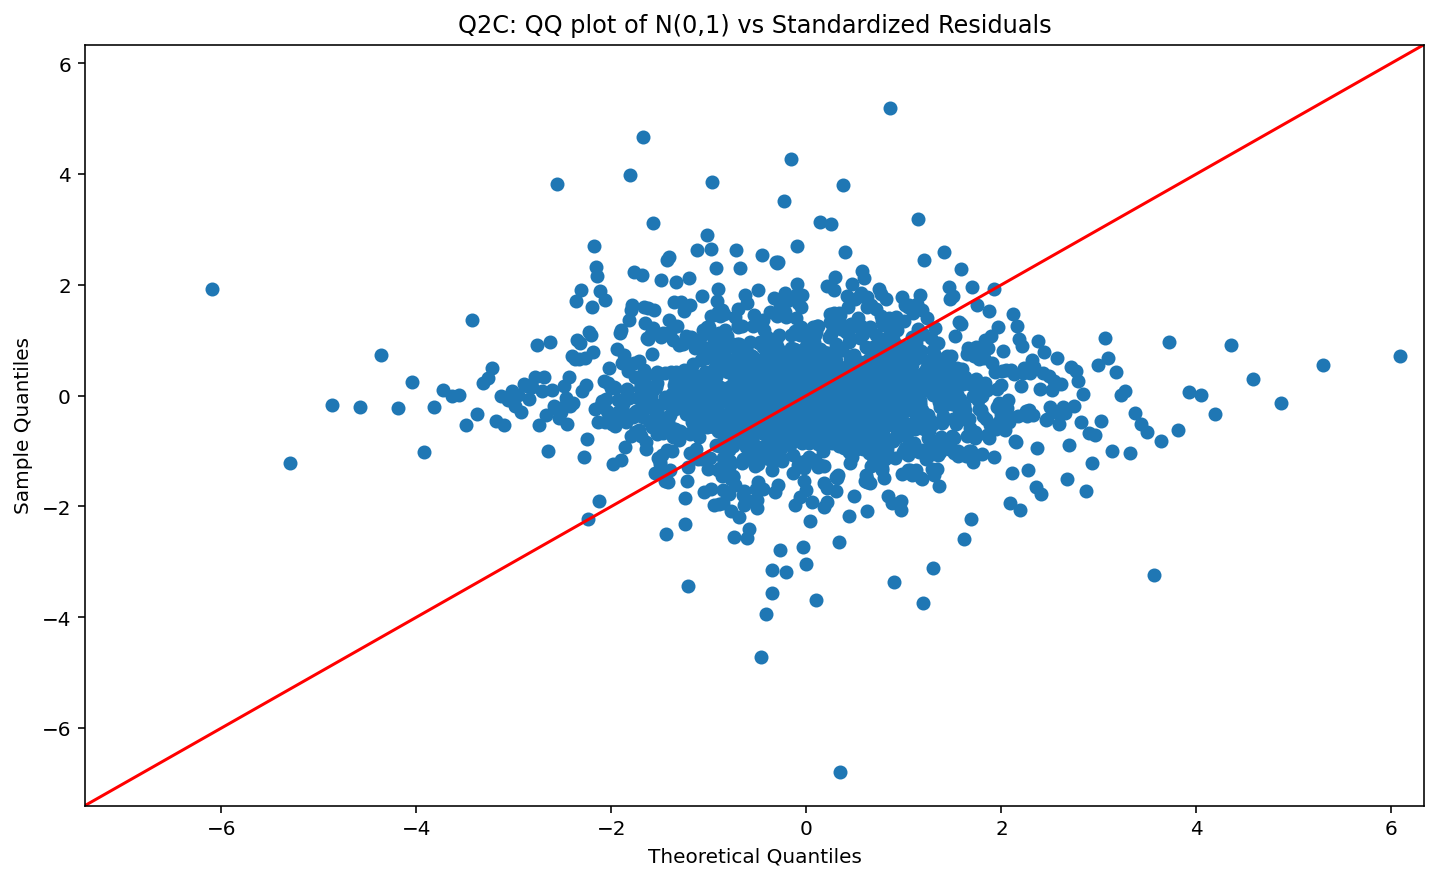

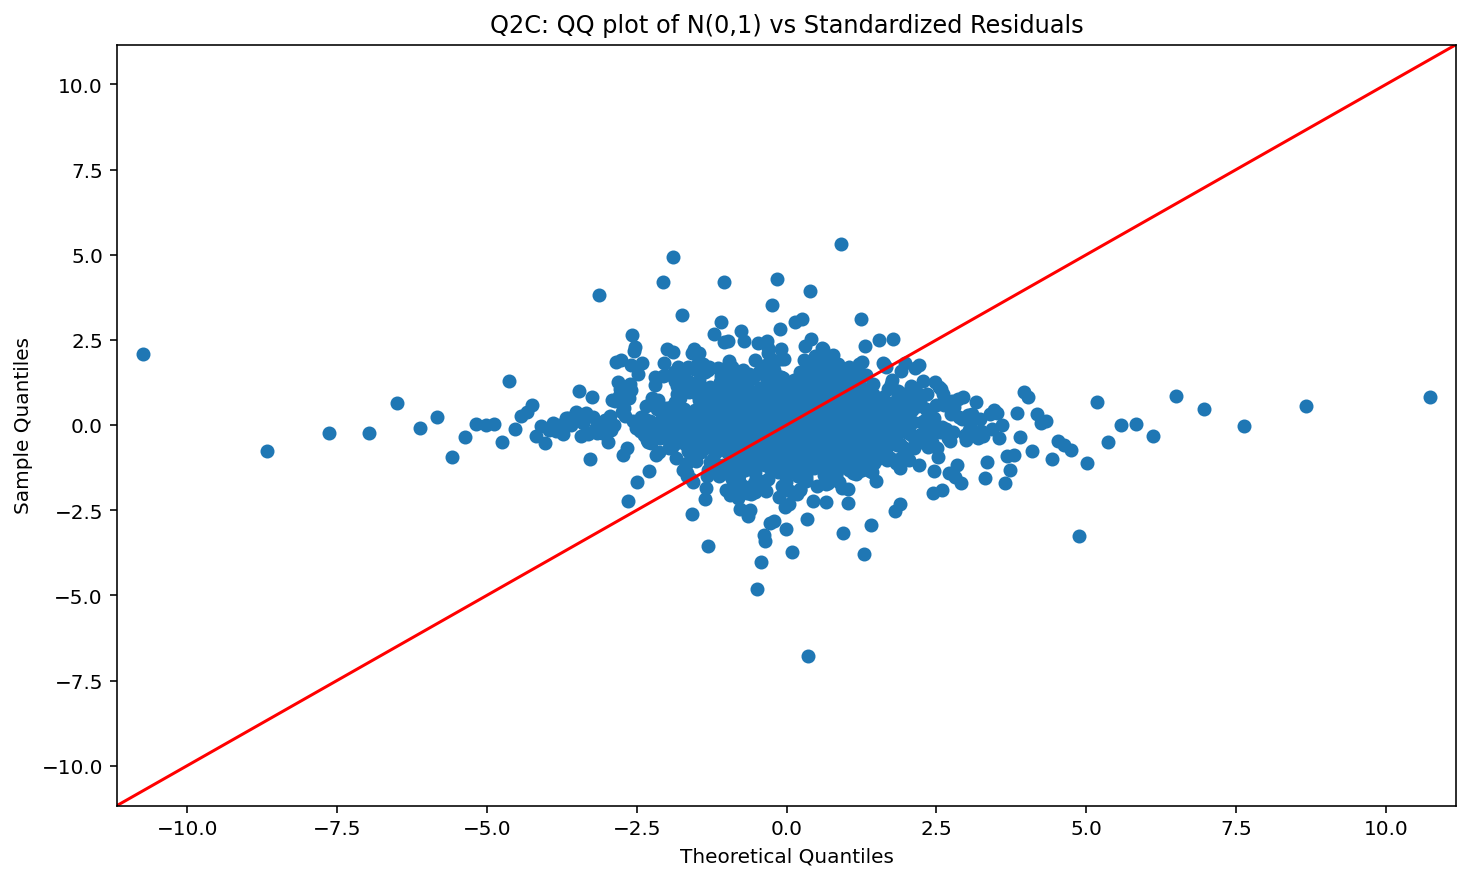

In [21]:
# The autograder will give up to 2 points for your calculations.
# I'll give up to 1 bonus point for your plots.

# Here's some parameters to try
ARCH_params = pd.Series([0.285, 0.0849, 0.0639, 2.0871, 0.1399, 0.8247, 5.6972],
                    index=['Const', 'CBETHUSD[1]', 'CBETHUSD[2]', 'omega', 'alpha[1]', 'beta[1]', 'nu'])

#Let's generate some volatilities for r_ETH
ETH_var = GARCH_PPplot(r_ETH,ARCH_params)

assert np.allclose(ETH_var.tail(4).values, 
                [[5.36530879], [5.11908247], [4.87455881], [4.7613757]],
                  rtol=1e-4)
assert np.allclose(ETH_var.head(5).values, 
                [[7.67838701], [7.67838701], [7.67838701], [9.02152163], [9.28454706]],
                  rtol=1e-4)

# Let's try something else
ARCH_params = pd.Series([ 0.2285, -0.0849,  0.0329,  2.2393,  0.1542,  0.8139, 3.3226],
                    index=['Const', 'CBETHUSD[1]', 'CBETHUSD[2]', 'omega', 'alpha[1]', 'beta[1]', 'nu'])

#Let's generate some volatilities for r_ETH
ETH_var = GARCH_PPplot(r_ETH,ARCH_params)

assert np.allclose(ETH_var.tail(4).values, 
                [[5.45783296], [5.23910772], [4.95787208], [4.8433725 ]], rtol=1e-4)
assert np.allclose(ETH_var.head(5).values, 
                [[ 8.37907907], [ 8.37907907], [ 8.37907907], [10.29700267], [ 9.88575638]], rtol=1e-4)



## Part c

Write a function that 

- accepts the parameter vector and a data series for a AR(2)-GARCH(1,1) model with t-distributed errors
- graphs the conditional volatility estimates
- and returns the log of the likelihood function.

You should assume that 

- the parameters are in the same order and have the same names as those reported by ARCH.
- $h_1 = h_2 = \frac{\alpha_0}{1 - \alpha_1 - \gamma_1}$<br>(ARCH uses a slightly different starting variance estimate, so you won't be able to perfectly match their llf.)



In [18]:
def GARCHt_llf(y,theta):  
    """
    Computes the llf of an AR(2)-GARCH(1,1) with Student-t errors
    Arguments:
        y         [Series] data series
        theta     [Series] parameters (same order & names as reported by ARCH)
    Returns:
        llf       [float] log likelihood function
    """
    ### BEGIN SOLUTION

    # This just re-uses most of the code from part (b)

    # calculate the squared residuals of the AR(2)
    ar_res = y - theta.iloc[0] - theta.iloc[1]*y.shift(1) - theta.iloc[2]*y.shift(2)
    res_sq = ar_res**2

    # set up some scalars for speed in the loop
    alpha0 = theta.iloc[3]
    alpha1 = theta.iloc[4]
    gamma1 = theta.iloc[5]

    # create df for variances 
    # use unconditional variance as the starting value
    h = (alpha0/(1-alpha1-gamma1)) * np.ones_like(y)

    # start the loop at t=3 because the residuals start at t=2
    for j in range(2,len(y)-1):
        h[j+1] = alpha0 + alpha1*res_sq.iloc[j] + gamma1*h[j] 

    ARCH_vol = pd.DataFrame(np.sqrt(h),index=y.index)
    ARCH_vol.plot(title='Estimated Volatility: AR(2)-GARCH(1,1) with Student-t errors')

    # Now we need to add some new code....
    # Calculate the llf, dropping the first 2 observations for NA's
    llf = np.sum(t.logpdf(ar_res.tail(-2),df=theta.iloc[6],scale=ARCH_vol.tail(-2)))

    ### END SOLUTION
    return llf

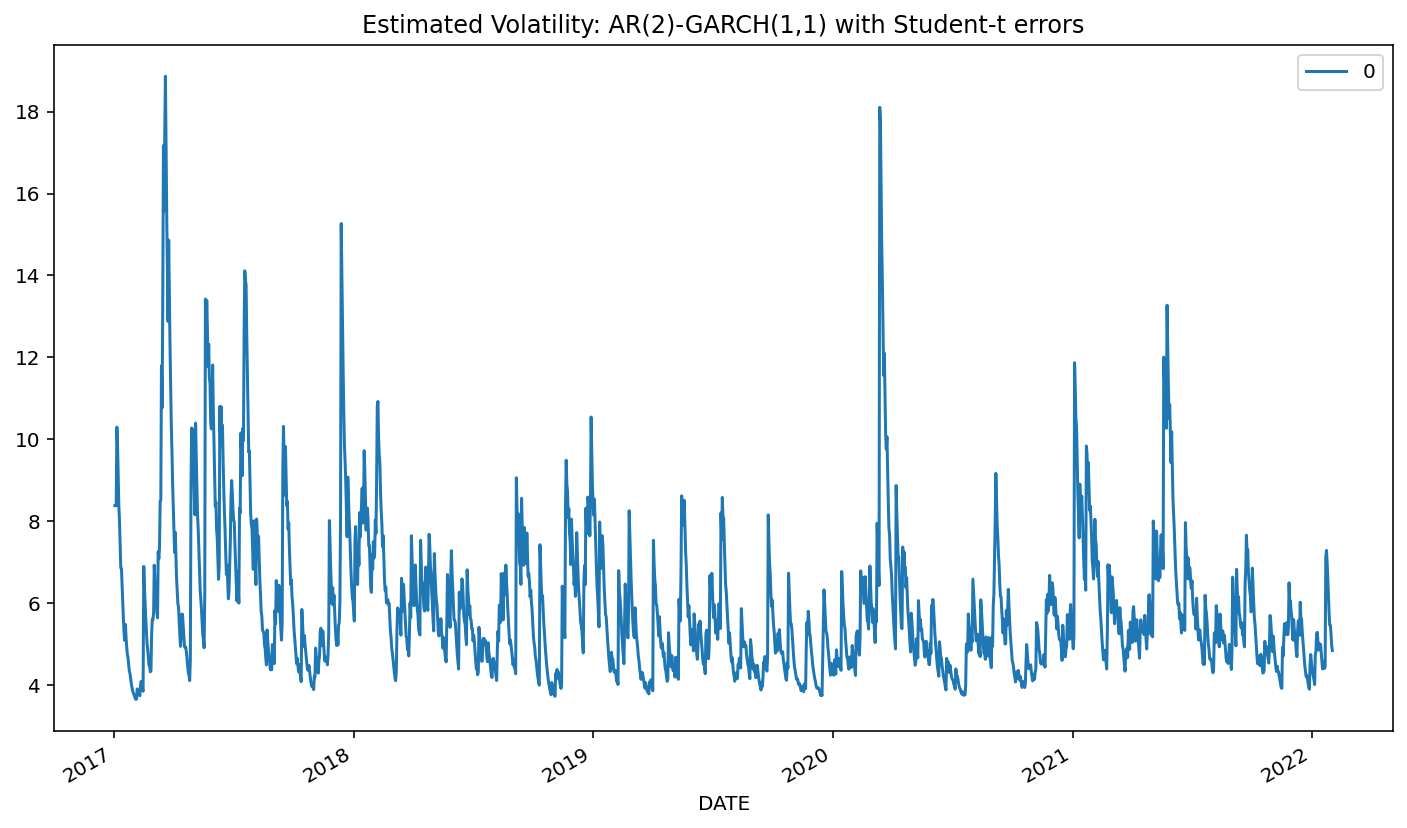

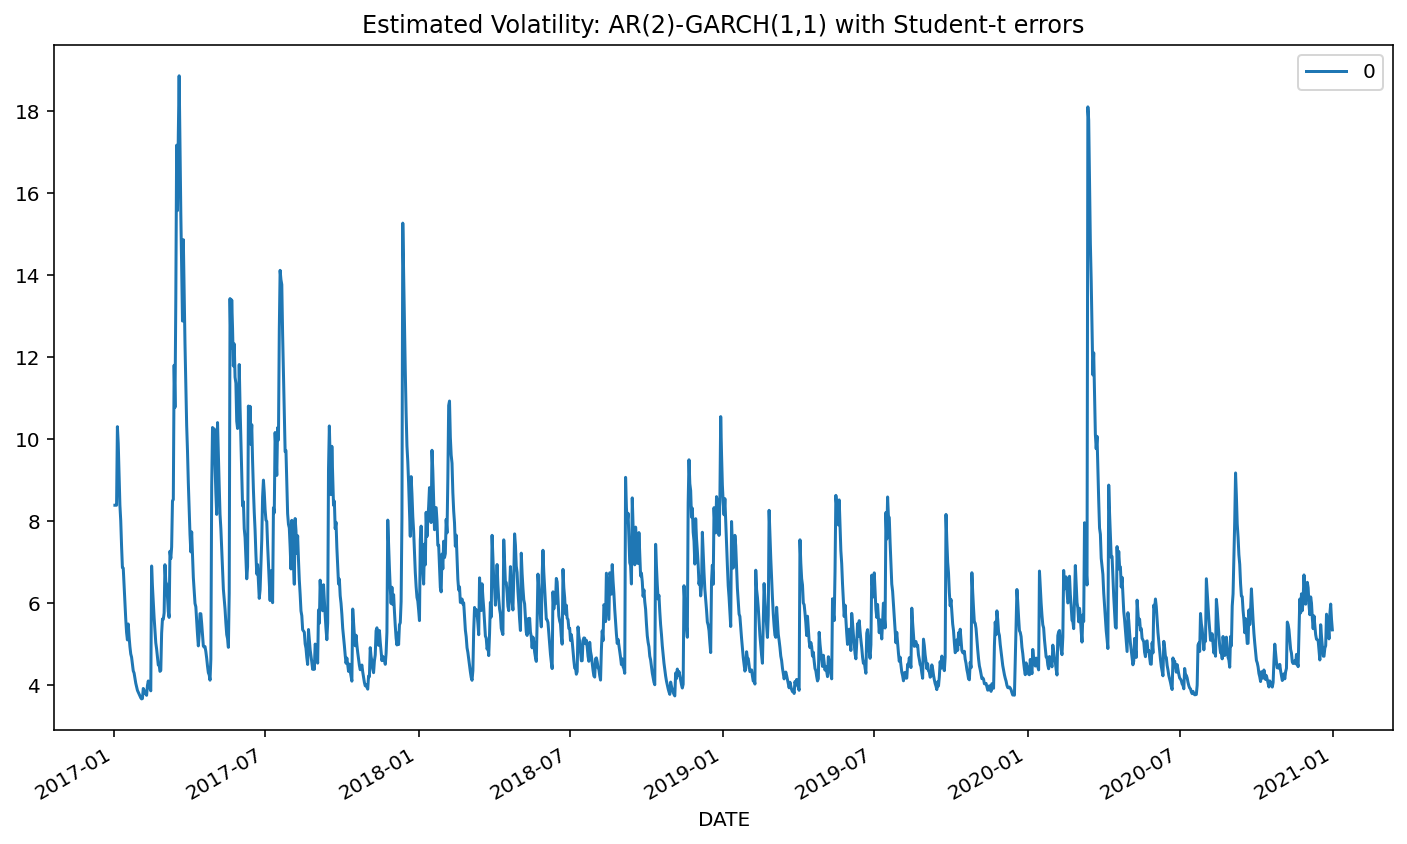

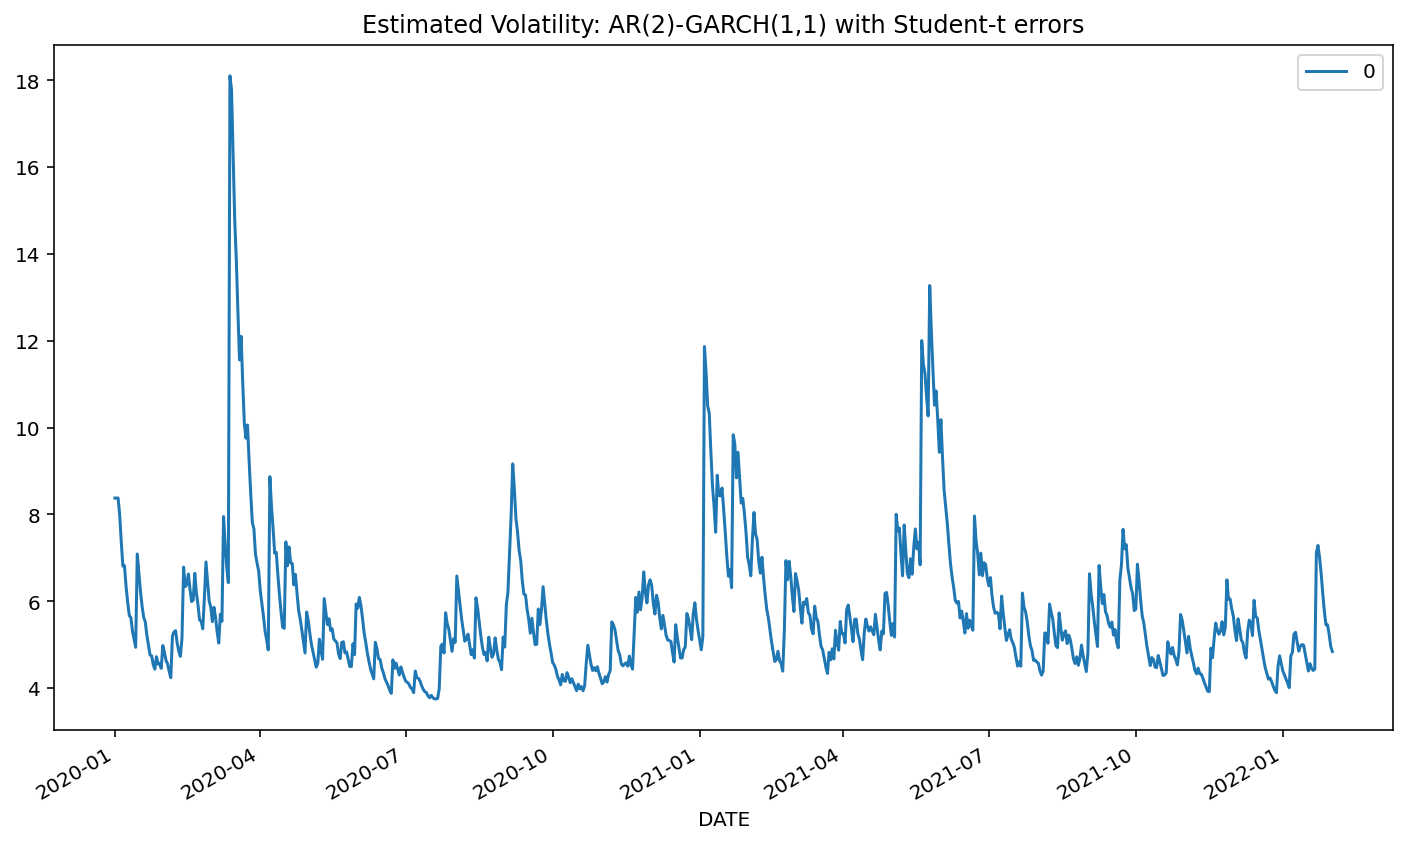

In [19]:
# The autograder will give up to 2 points for your calculations.
# I'll give up to 1 bonus point for your plots.

# Here's some parameters to try
ARCH_params = pd.Series([ 0.2285, -0.0849,  0.0329,  2.2393,  0.1542,  0.8139, 3.3226],
                    index=['Const', 'CBETHUSD[1]', 'CBETHUSD[2]', 'omega', 'alpha[1]', 'beta[1]', 'nu'])
assert np.isclose(GARCHt_llf(r_ETH,ARCH_params),-5778.913218630075, atol=1e-4)
assert np.isclose(GARCHt_llf(r_ETH['2017':'2020'],ARCH_params), -4532.593141333698, atol=1e-4)
assert np.isclose(GARCHt_llf(r_ETH['2020':],ARCH_params), -2347.389072003322, atol=1e-4)
